In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.font_manager as fm
import os


In [16]:
def generate_graphs():
    graphs = {}
    sizes = [10, 50, 100, 200]  # 異なるグラフサイズ
    for size in sizes:
        # Erdős-Rényiグラフ
        p = 0.1  # エッジ確率
        er_graph = nx.erdos_renyi_graph(n=size, p=p, seed=42)
        if nx.is_connected(er_graph):
            graphs[f"ER_{size}"] = er_graph
        else:
            # 連結でない場合、最大の連結成分を選択
            largest_cc = max(nx.connected_components(er_graph), key=len)
            er_graph = er_graph.subgraph(largest_cc).copy()
            graphs[f"ER_{size}"] = er_graph

        # Barabási-Albertグラフ
        m = 3  # 新しいノードが接続する既存ノードの数
        ba_graph = nx.barabasi_albert_graph(n=size, m=m, seed=42)
        graphs[f"BA_{size}"] = ba_graph

    return graphs


In [17]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x, adj):
        # 隣接行列に自己ループを追加
        adj = adj + torch.eye(adj.size(0))
        # 正規化
        degree = torch.sum(adj, dim=1)
        D_inv_sqrt = torch.diag(torch.pow(degree, -0.5))
        adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
        # メッセージパッシング
        x = adj_normalized @ x
        x = self.linear(x)
        return F.relu(x)

class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        if num_layers == 1:
            self.layers.append(GCNLayer(in_features, out_features))
        else:
            self.layers.append(GCNLayer(in_features, hidden_features))
            for _ in range(num_layers - 2):
                self.layers.append(GCNLayer(hidden_features, hidden_features))
            self.layers.append(GCNLayer(hidden_features, out_features))
    
    def forward(self, x, adj):
        for layer in self.layers:
            x = layer(x, adj)
        return x


In [18]:
def compute_cosine_similarity(x):
    # ノード間のコサイン類似度を計算
    x_norm = F.normalize(x, p=2, dim=1)
    similarity = torch.mm(x_norm, x_norm.t())
    # 対角成分を除外
    mask = ~torch.eye(similarity.size(0), dtype=bool)
    similarity = similarity[mask].mean().item()
    return similarity


Processing graph: ER_10 with 9 nodes
Processing graph: BA_10 with 10 nodes
Processing graph: ER_50 with 50 nodes
Processing graph: BA_50 with 50 nodes
Processing graph: ER_100 with 100 nodes
Processing graph: BA_100 with 100 nodes
Processing graph: ER_200 with 200 nodes
Processing graph: BA_200 with 200 nodes


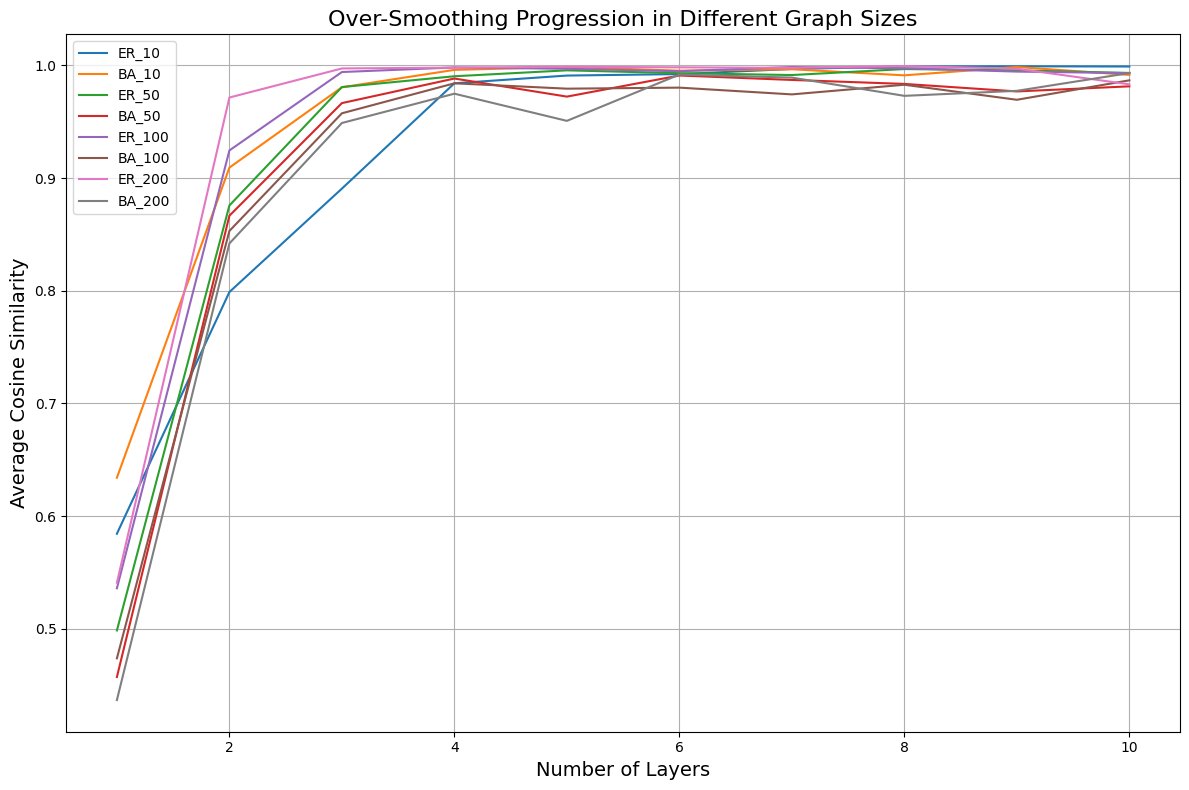

In [19]:
def main():
    # グラフの生成
    graphs = generate_graphs()
    
    # GNNの設定
    in_features = 16
    hidden_features = 16
    out_features = 16
    num_layers = 10  # 多層でオーバースムージングを観察
    gnn = GCN(in_features, hidden_features, out_features, num_layers)
    
    # 各グラフに対して実験
    results = {}
    for name, G in graphs.items():
        print(f"Processing graph: {name} with {G.number_of_nodes()} nodes")
        num_nodes = G.number_of_nodes()
        # 隣接行列の作成
        adj = nx.adjacency_matrix(G).todense()
        adj = torch.tensor(adj, dtype=torch.float)
        # 初期特徴量の設定（ランダム）
        x = torch.randn((num_nodes, in_features))
        # GNNの重みを初期化
        gnn.apply(lambda m: isinstance(m, nn.Linear) and nn.init.xavier_uniform_(m.weight))
        # レイヤーごとの類似度を記録
        similarities = []
        current_x = x
        for layer in gnn.layers:
            current_x = layer(current_x, adj)
            sim = compute_cosine_similarity(current_x)
            similarities.append(sim)
        results[name] = similarities
    
    # 可視化
    plt.figure(figsize=(12, 8))
    for name, sims in results.items():
        layers = list(range(1, len(sims) + 1))
        plt.plot(layers, sims, label=name)
    
    plt.xlabel('Number of Layers', fontsize=14)
    plt.ylabel('Average Cosine Similarity', fontsize=14)
    plt.title('Over-Smoothing Progression in Different Graph Sizes', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [20]:
def generate_random_graphs():
    graphs = {}
    sizes = [10, 50, 100, 200]  # Different graph sizes
    for size in sizes:
        p = 0.05  # Probability for edge creation; adjust as needed
        er_graph = nx.erdos_renyi_graph(n=size, p=p, seed=42)
        if not nx.is_connected(er_graph):
            largest_cc = max(nx.connected_components(er_graph), key=len)
            er_graph = er_graph.subgraph(largest_cc).copy()
            print(f"ER Graph with {size} nodes is not connected. Using largest connected component with {er_graph.number_of_nodes()} nodes.")
        graphs[f"ER_{er_graph.number_of_nodes()}"] = er_graph
    return graphs


In [21]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x, adj):
        # Add self-loops
        adj = adj + torch.eye(adj.size(0))
        # Normalize adjacency matrix
        degree = torch.sum(adj, dim=1)
        D_inv_sqrt = torch.diag(torch.pow(degree, -0.5))
        adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
        # Graph convolution
        x = adj_normalized @ x
        x = self.linear(x)
        return F.relu(x)

class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        if num_layers == 1:
            self.layers.append(GCNLayer(in_features, out_features))
        else:
            self.layers.append(GCNLayer(in_features, hidden_features))
            for _ in range(num_layers - 2):
                self.layers.append(GCNLayer(hidden_features, hidden_features))
            self.layers.append(GCNLayer(hidden_features, out_features))
    
    def forward(self, x, adj):
        for layer in self.layers:
            x = layer(x, adj)
        return x


In [22]:
def compute_average_cosine_similarity(x):
    # Normalize features
    x_norm = F.normalize(x, p=2, dim=1)
    # Compute cosine similarity matrix
    similarity_matrix = torch.mm(x_norm, x_norm.t())
    # Exclude self-similarity by masking the diagonal
    mask = ~torch.eye(similarity_matrix.size(0), dtype=torch.bool)
    similarity = similarity_matrix.masked_select(mask).mean().item()
    return similarity


In [23]:
def visualize_graph(G, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [24]:
def main():
    # Generate graphs
    graphs = generate_random_graphs()
    
    # Visualize each graph
    for name, G in graphs.items():
        visualize_graph(G, f"Graph: {name} Nodes")
    
    # GCN settings
    in_features = 16
    hidden_features = 16
    out_features = 16
    num_layers = 10  # Number of GCN layers to observe over-smoothing
    gcn = GCN(in_features, hidden_features, out_features, num_layers)
    
    # Initialize weights
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
    gcn.apply(init_weights)
    
    # Prepare results storage
    results = {}
    
    # Process each graph
    for name, G in graphs.items():
        print(f"Processing Graph: {name} with {G.number_of_nodes()} nodes")
        num_nodes = G.number_of_nodes()
        # Adjacency matrix
        adj = nx.adjacency_matrix(G).todense()
        adj = torch.tensor(adj, dtype=torch.float)
        # Initial node features (random)
        x = torch.randn((num_nodes, in_features))
        # Record similarities
        similarities = []
        current_x = x
        for layer_idx, layer in enumerate(gcn.layers, 1):
            current_x = layer(current_x, adj)
            sim = compute_average_cosine_similarity(current_x)
            similarities.append(sim)
            print(f"  Layer {layer_idx}: Avg Cosine Similarity = {sim:.4f}")
        results[name] = similarities
    
    # Plot over-smoothing progression
    plt.figure(figsize=(12, 8))
    for name, sims in results.items():
        layers = list(range(1, len(sims) + 1))
        plt.plot(layers, sims, label=name)
    
    plt.xlabel('Number of GCN Layers', fontsize=14)
    plt.ylabel('Average Cosine Similarity', fontsize=14)
    plt.title('Over-Smoothing Progression in GCNs Across Different Graph Sizes', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


ER Graph with 10 nodes is not connected. Using largest connected component with 4 nodes.
ER Graph with 50 nodes is not connected. Using largest connected component with 44 nodes.


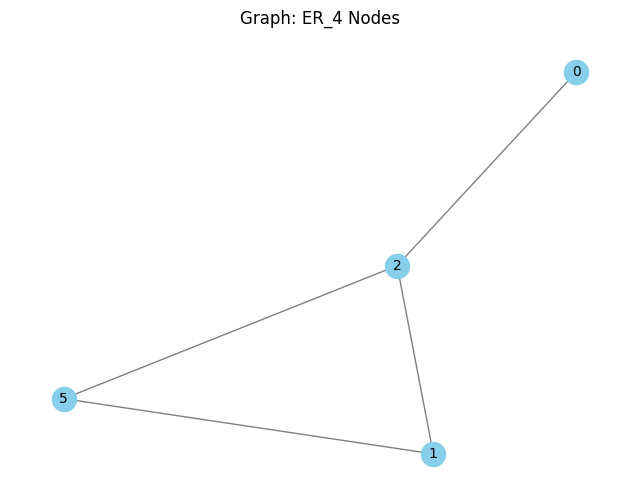

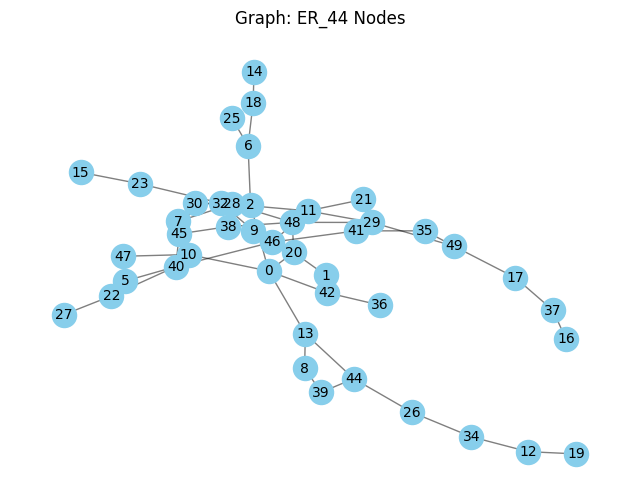

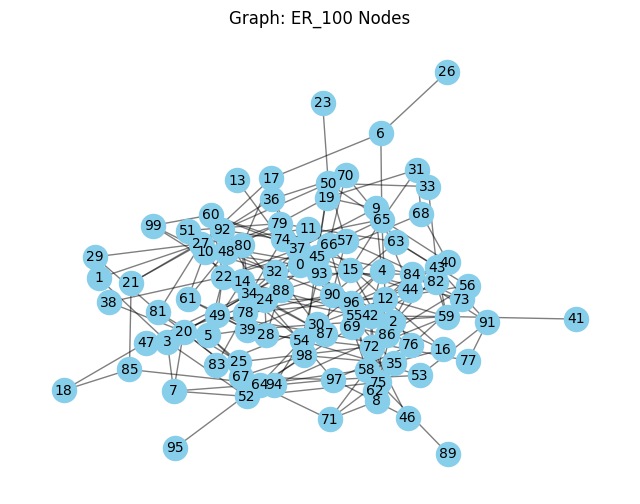

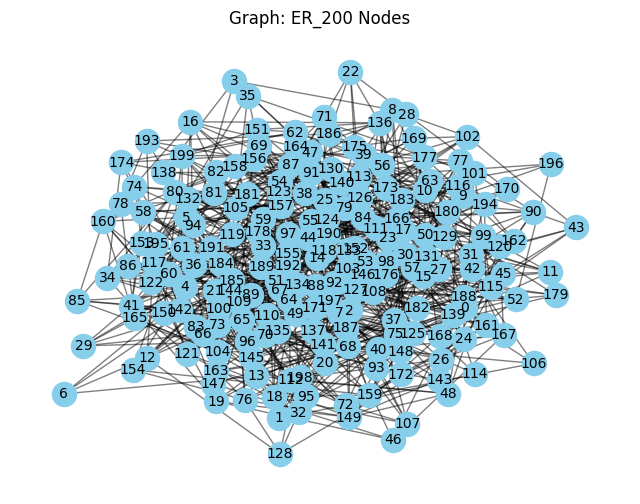

Processing Graph: ER_4 with 4 nodes
  Layer 1: Avg Cosine Similarity = 0.8634
  Layer 2: Avg Cosine Similarity = 0.9510
  Layer 3: Avg Cosine Similarity = 0.9970
  Layer 4: Avg Cosine Similarity = 0.9985
  Layer 5: Avg Cosine Similarity = 0.9988
  Layer 6: Avg Cosine Similarity = 0.9959
  Layer 7: Avg Cosine Similarity = 0.9984
  Layer 8: Avg Cosine Similarity = 0.9625
  Layer 9: Avg Cosine Similarity = 0.9973
  Layer 10: Avg Cosine Similarity = 0.9991
Processing Graph: ER_44 with 44 nodes
  Layer 1: Avg Cosine Similarity = 0.4343
  Layer 2: Avg Cosine Similarity = 0.6018
  Layer 3: Avg Cosine Similarity = 0.8940
  Layer 4: Avg Cosine Similarity = 0.9735
  Layer 5: Avg Cosine Similarity = 0.9914
  Layer 6: Avg Cosine Similarity = 0.9950
  Layer 7: Avg Cosine Similarity = 0.9982
  Layer 8: Avg Cosine Similarity = 0.9690
  Layer 9: Avg Cosine Similarity = 0.9982
  Layer 10: Avg Cosine Similarity = 0.9994
Processing Graph: ER_100 with 100 nodes
  Layer 1: Avg Cosine Similarity = 0.4575
  

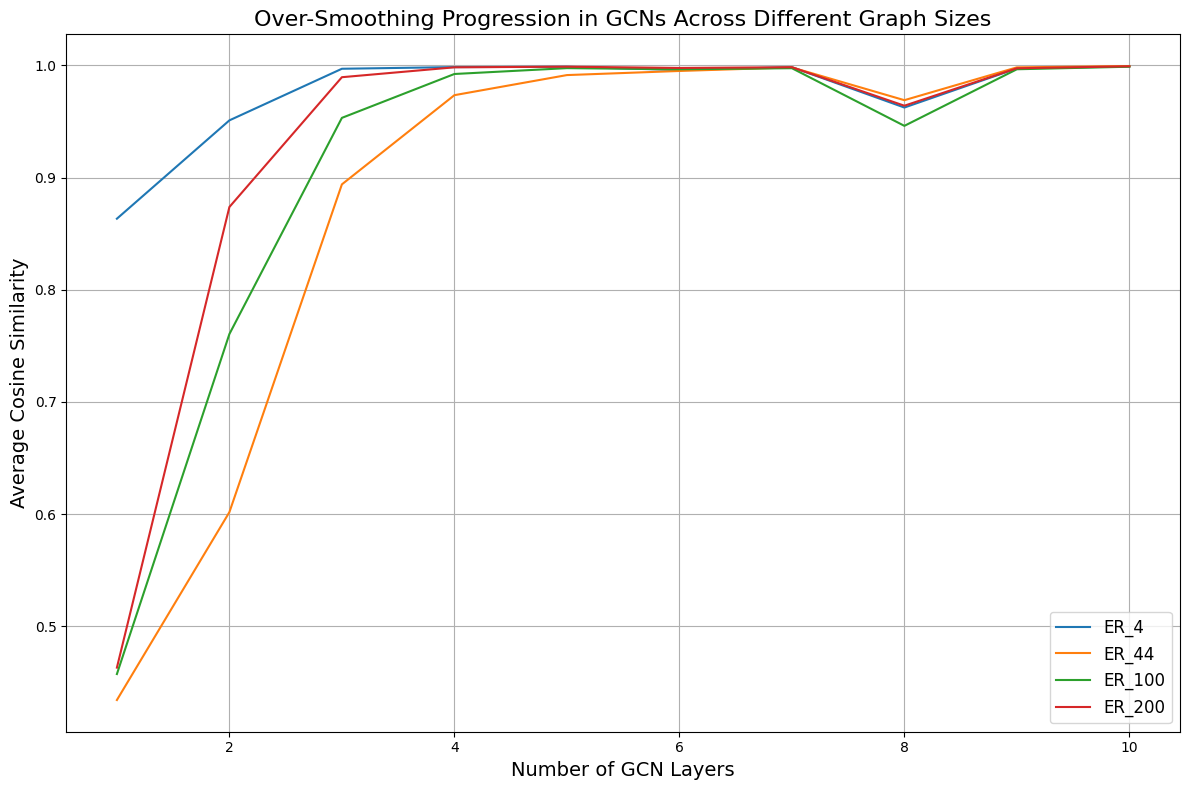

In [25]:
if __name__ == "__main__":
    main()


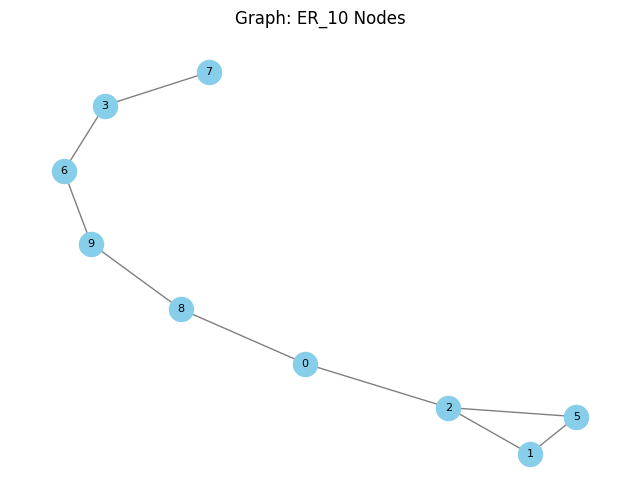

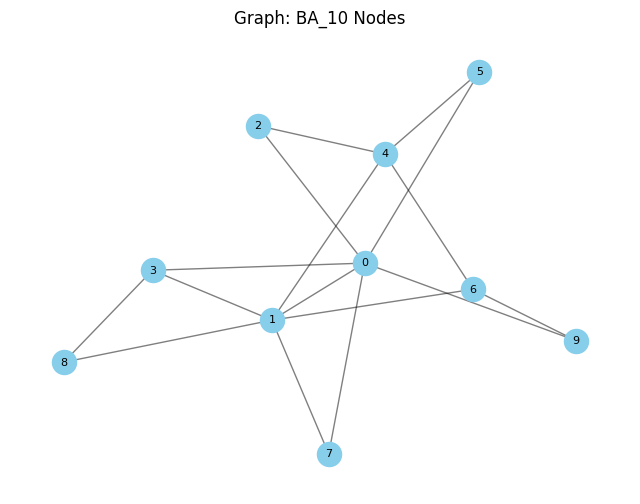

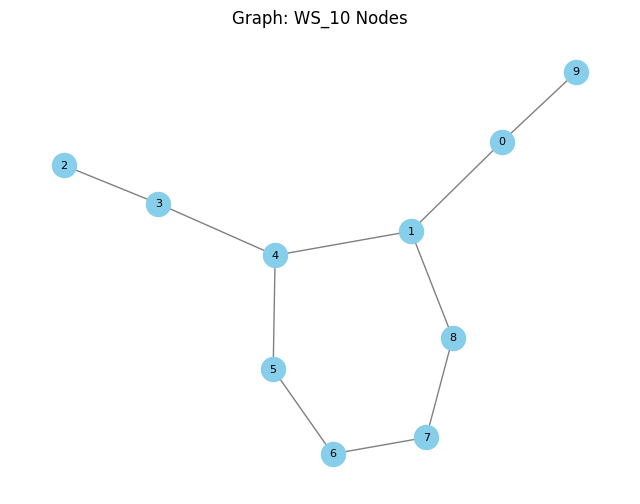

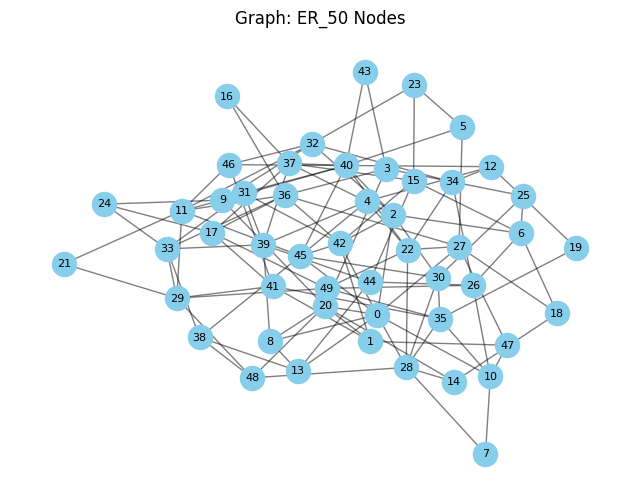

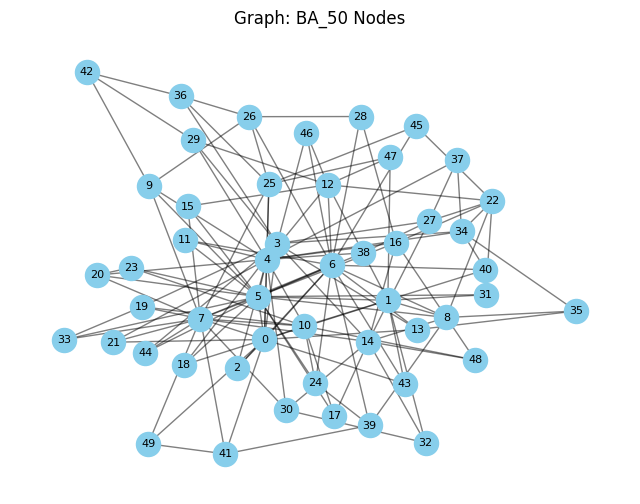

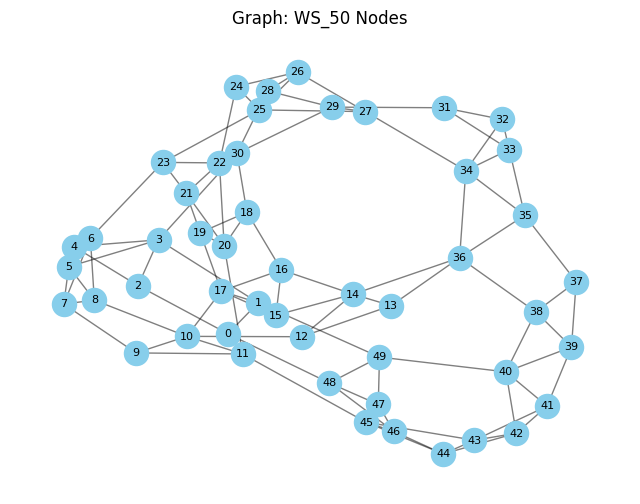

Graph: ER_100 Nodes is too large to visualize effectively.
Graph: BA_100 Nodes is too large to visualize effectively.
Graph: WS_100 Nodes is too large to visualize effectively.
Graph: ER_200 Nodes is too large to visualize effectively.
Graph: BA_200 Nodes is too large to visualize effectively.
Graph: WS_200 Nodes is too large to visualize effectively.
Processing Graph: ER_10 with 9 nodes
  Layer 1: Avg Cosine Similarity = 0.4920, Feature Variance = 0.5511
  Layer 2: Avg Cosine Similarity = 0.7717, Feature Variance = 0.1529
  Layer 3: Avg Cosine Similarity = 0.8715, Feature Variance = 0.0533
  Layer 4: Avg Cosine Similarity = 0.9288, Feature Variance = 0.0263
  Detected Anomalies: [0]

Processing Graph: BA_10 with 10 nodes
  Layer 1: Avg Cosine Similarity = 0.4247, Feature Variance = 0.2483
  Layer 2: Avg Cosine Similarity = 0.8510, Feature Variance = 0.0250
  Layer 3: Avg Cosine Similarity = 0.9357, Feature Variance = 0.0027
  Layer 4: Avg Cosine Similarity = 0.9921, Feature Variance =

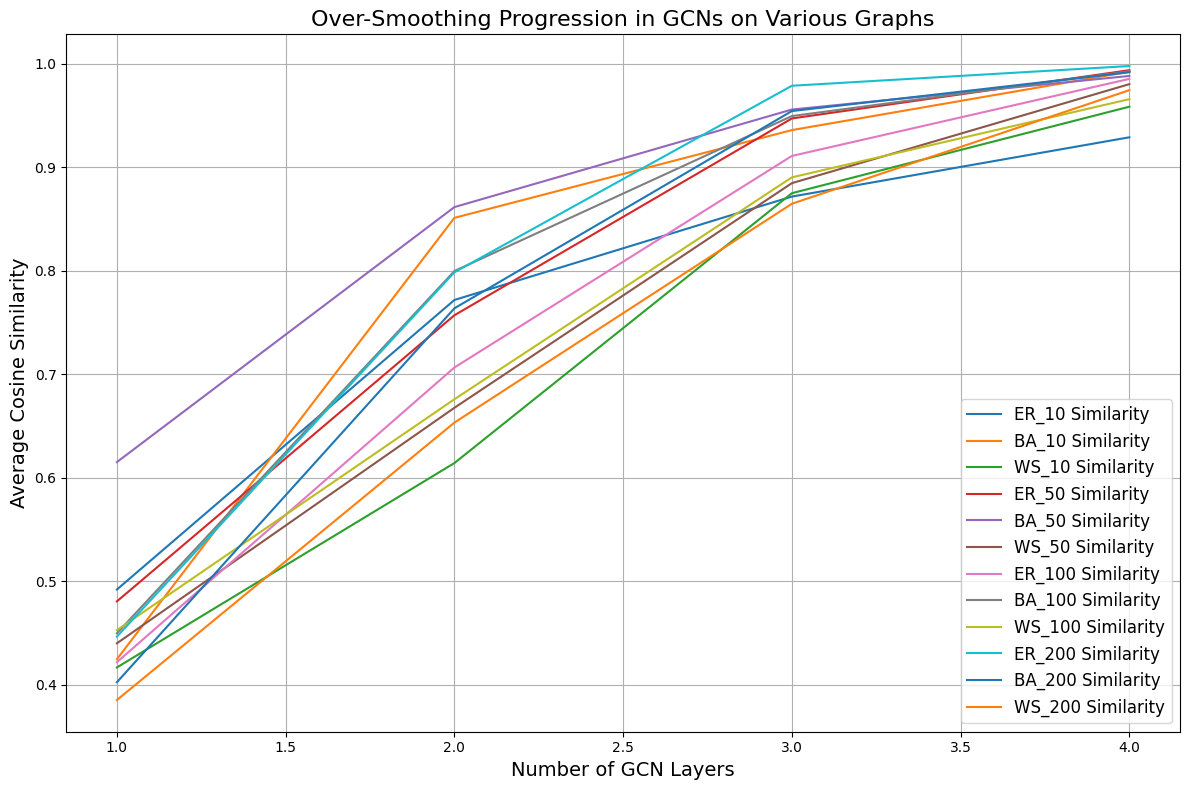

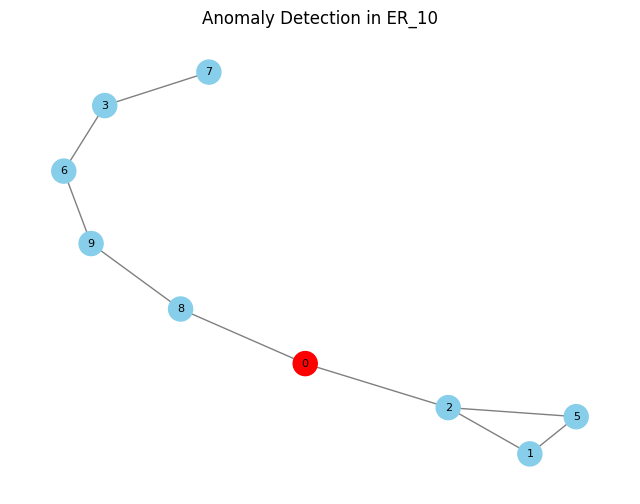

Anomaly Detection Evaluation for ER_10:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000



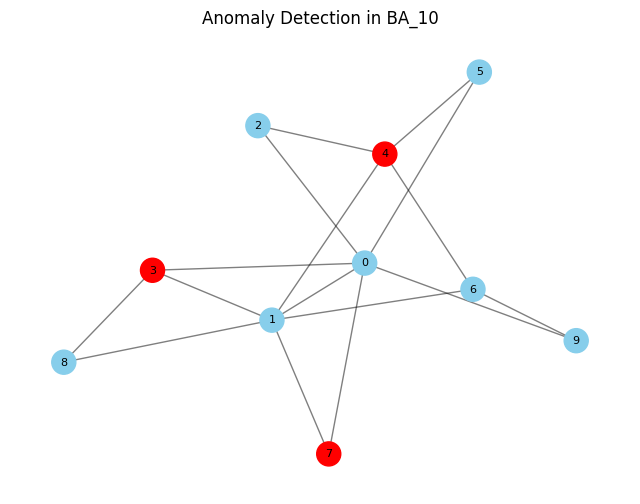

Anomaly Detection Evaluation for BA_10:
  Precision: 0.3333, Recall: 1.0000, F1-Score: 0.5000



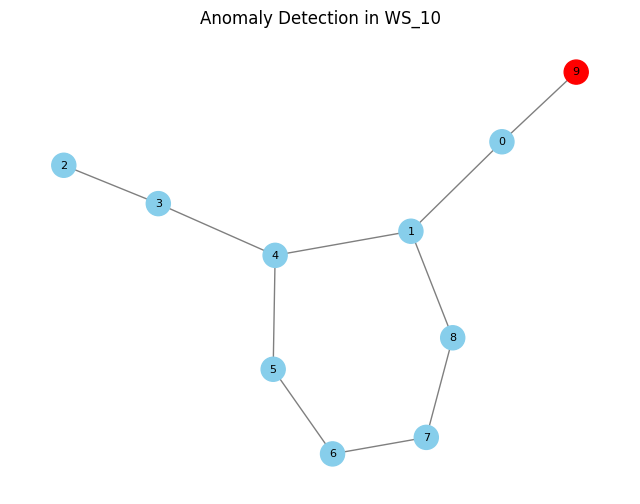

Anomaly Detection Evaluation for WS_10:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000



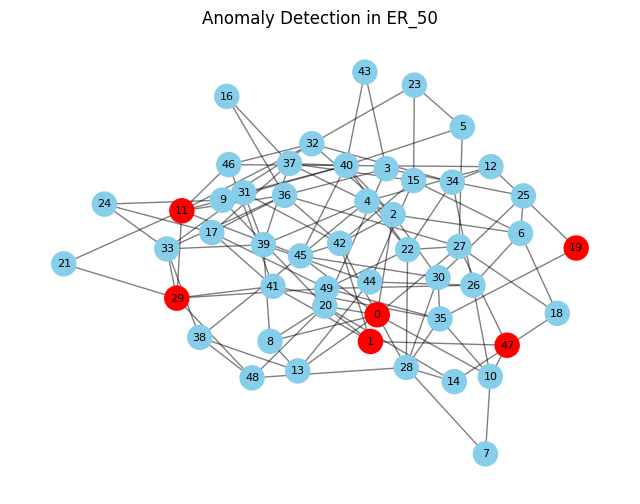

Anomaly Detection Evaluation for ER_50:
  Precision: 0.1667, Recall: 0.5000, F1-Score: 0.2500



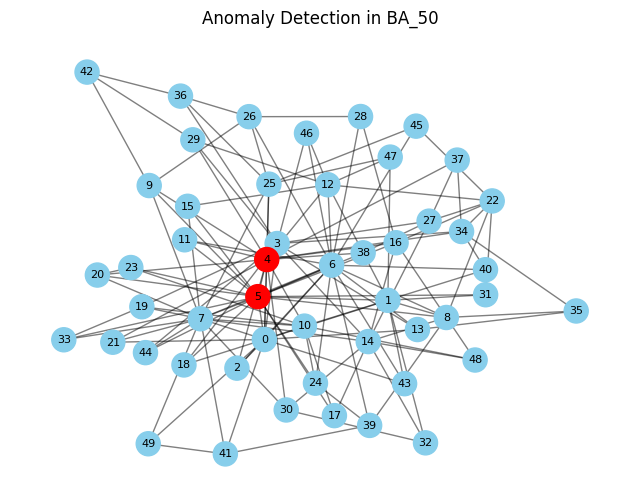

Anomaly Detection Evaluation for BA_50:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000



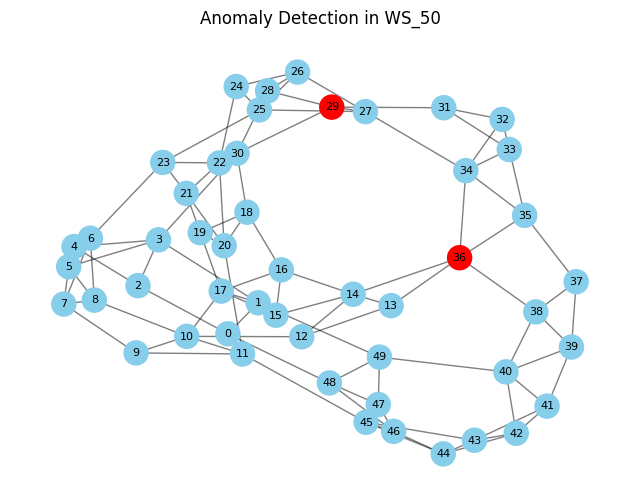

Anomaly Detection Evaluation for WS_50:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

Anomalies detected in ER_100, but graph is too large to visualize effectively.
Anomaly Detection Evaluation for ER_100:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

Anomalies detected in BA_100, but graph is too large to visualize effectively.
Anomaly Detection Evaluation for BA_100:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

Anomalies detected in WS_100, but graph is too large to visualize effectively.
Anomaly Detection Evaluation for WS_100:
  Precision: 0.2500, Recall: 0.2000, F1-Score: 0.2222

Anomalies detected in ER_200, but graph is too large to visualize effectively.
Anomaly Detection Evaluation for ER_200:
  Precision: 0.2500, Recall: 0.1000, F1-Score: 0.1429

Anomalies detected in BA_200, but graph is too large to visualize effectively.
Anomaly Detection Evaluation for BA_200:
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

Anomalies detected in WS_200, 

In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    
    def forward(self, x, adj):
        # 自己ループの追加
        adj = adj + torch.eye(adj.size(0))
        # 隣接行列の正規化
        degree = torch.sum(adj, dim=1)
        D_inv_sqrt = torch.diag(torch.pow(degree, -0.5))
        adj_normalized = D_inv_sqrt @ adj @ D_inv_sqrt
        # グラフ畳み込み
        x = adj_normalized @ x
        x = self.linear(x)
        return F.relu(x)

class GCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers):
        super(GCN, self).__init__()
        self.layers = nn.ModuleList()
        if num_layers == 1:
            self.layers.append(GCNLayer(in_features, out_features))
        else:
            self.layers.append(GCNLayer(in_features, hidden_features))
            for _ in range(num_layers - 2):
                self.layers.append(GCNLayer(hidden_features, hidden_features))
            self.layers.append(GCNLayer(hidden_features, out_features))
    
    def forward(self, x, adj):
        for layer in self.layers:
            x = layer(x, adj)
        return x
def compute_average_cosine_similarity(x):
    x_norm = F.normalize(x, p=2, dim=1)
    similarity_matrix = torch.mm(x_norm, x_norm.t())
    mask = ~torch.eye(similarity_matrix.size(0), dtype=torch.bool)
    similarity = similarity_matrix.masked_select(mask).mean().item()
    return similarity
def detect_anomalies_with_clustering(features, num_clusters=2, threshold_ratio=0.8):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    distances = kmeans.transform(features).min(axis=1)
    threshold = threshold_ratio * distances.max()
    anomalies = np.where(distances > threshold)[0]
    return anomalies
def generate_graphs():
    graphs = {}
    sizes = [10, 50, 100, 200]
    graph_types = ['ER', 'BA', 'WS']
    for size in sizes:
        # Erdős-Rényiランダムグラフ
        p = 0.1 if size <= 50 else 0.05
        er_graph = nx.erdos_renyi_graph(n=size, p=p, seed=42)
        if not nx.is_connected(er_graph):
            er_graph = er_graph.subgraph(max(nx.connected_components(er_graph), key=len)).copy()
        graphs[f"ER_{size}"] = er_graph
        
        # Barabási-Albertスケールフリーネットワーク
        m = 3 if size >= 50 else 2
        ba_graph = nx.barabasi_albert_graph(n=size, m=m, seed=42)
        graphs[f"BA_{size}"] = ba_graph
        
        # Watts-Strogatz小世界ネットワーク
        k = 4 if size >= 50 else 2
        p_ws = 0.1
        ws_graph = nx.watts_strogatz_graph(n=size, k=k, p=p_ws, seed=42)
        graphs[f"WS_{size}"] = ws_graph
    return graphs
def visualize_graph(G, title):
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    if G.number_of_nodes() <= 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()
def main():
    graphs = generate_graphs()
    
    # グラフの可視化（小規模グラフのみ）
    for name, G in graphs.items():
        if G.number_of_nodes() <= 50:
            visualize_graph(G, f"Graph: {name} Nodes")
        else:
            print(f"Graph: {name} Nodes is too large to visualize effectively.")
    
    # GCNの設定
    in_features = 16
    hidden_features = 16
    out_features = 16
    num_layers = 4  # オーバースムージングを観察するための層数
    gcn = GCN(in_features, hidden_features, out_features, num_layers)
    
    # 重みの初期化
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
    gcn.apply(init_weights)
    
    # 異常検知の結果を格納する辞書
    results = {}
    anomalies_dict = {}
    ground_truth_dict = {}
    
    # 各グラフに対する処理
    for name, G in graphs.items():
        print(f"Processing Graph: {name} with {G.number_of_nodes()} nodes")
        num_nodes = G.number_of_nodes()
        adj = nx.adjacency_matrix(G).todense()
        adj = torch.tensor(adj, dtype=torch.float)
        x = torch.randn((num_nodes, in_features))
        
        # 異常ノードの注入
        anomaly_ratio = 0.05  # 5%のノードを異常とする
        num_anomalies = max(1, int(anomaly_ratio * num_nodes))
        anomaly_indices = np.random.choice(num_nodes, num_anomalies, replace=False)
        ground_truth = np.zeros(num_nodes, dtype=int)
        ground_truth[anomaly_indices] = 1  # 異常ノードを1とする
        
        # 異常ノードの特徴量を変更（ノイズを追加）
        x[anomaly_indices] = torch.randn((num_anomalies, in_features)) * 5.0  # 通常の特徴量より大きなノイズ
        
        ground_truth_dict[name] = ground_truth
        
        # GCN層の適用と指標の計算
        similarities = []
        variances = []
        current_x = x
        for layer_idx, layer in enumerate(gcn.layers, 1):
            current_x = layer(current_x, adj)
            sim = compute_average_cosine_similarity(current_x)
            var = compute_feature_variance(current_x)
            similarities.append(sim)
            variances.append(var)
            print(f"  Layer {layer_idx}: Avg Cosine Similarity = {sim:.4f}, Feature Variance = {var:.4f}")
        
        results[name] = {'similarity': similarities, 'variance': variances}
        
        # 異常検知
        features = current_x.detach().numpy()
        anomalies = detect_anomalies_with_clustering(features, num_clusters=2, threshold_ratio=0.8)
        anomalies_dict[name] = anomalies
        print(f"  Detected Anomalies: {anomalies}\n")
    
    # オーバースムージングの進行をプロット
    plt.figure(figsize=(12, 8))
    for name, metrics in results.items():
        layers = list(range(1, len(metrics['similarity']) + 1))
        plt.plot(layers, metrics['similarity'], label=f"{name} Similarity")
    plt.xlabel('Number of GCN Layers', fontsize=14)
    plt.ylabel('Average Cosine Similarity', fontsize=14)
    plt.title('Over-Smoothing Progression in GCNs on Various Graphs', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 異常ノードの可視化と評価（小規模グラフのみ）
    for name, anomalies in anomalies_dict.items():
        G = graphs[name]
        ground_truth = ground_truth_dict[name]
        if len(anomalies) > 0 and G.number_of_nodes() <= 50:
            plt.figure(figsize=(8,6))
            pos = nx.spring_layout(G, seed=42)
            colors = ['red' if node in anomalies else 'skyblue' for node in G.nodes()]
            nx.draw_networkx_nodes(G, pos, node_size=300, node_color=colors)
            nx.draw_networkx_edges(G, pos, alpha=0.5)
            nx.draw_networkx_labels(G, pos, font_size=8)
            plt.title(f"Anomaly Detection in {name}")
            plt.axis('off')
            plt.show()
            
            # 精度評価
            predicted = np.zeros(G.number_of_nodes(), dtype=int)
            predicted[anomalies] = 1
            precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary', zero_division=0)
            print(f"Anomaly Detection Evaluation for {name}:")
            print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
        elif len(anomalies) > 0:
            print(f"Anomalies detected in {name}, but graph is too large to visualize effectively.")
            # 精度評価のみ実施
            predicted = np.zeros(G.number_of_nodes(), dtype=int)
            predicted[anomalies] = 1
            precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary', zero_division=0)
            print(f"Anomaly Detection Evaluation for {name}:")
            print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
        else:
            print(f"No anomalies detected in {name}.")
            # 精度評価のみ実施
            predicted = np.zeros(G.number_of_nodes(), dtype=int)
            precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predicted, average='binary', zero_division=0)
            print(f"Anomaly Detection Evaluation for {name}:")
            print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
if __name__ == "__main__":
    main()